# Description

This notebook is written to visualize an example set of bias adjustment results computed in this project's [BiasAdjust_model_run.ipynb](./BiasAdjust_model_run.ipynb) notebook. We examine the magnitude of the bias adjustment and it's geospatial and probability space structure.

# Setup

In [1]:
# import the packages we need to run this code
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utilities as util
import pickle

# import what we need for the statistical/visual comparison
from statsmodels.distributions.empirical_distribution import ECDF
import cartopy.crs as ccrs

# define the location to save the 
fig_main_savepath='./paper_figures/main/'
fig_si_savepath='./paper_figures/si/'

As an example we focus on GFDL-CM3 and July ('mon07'). 

The example location we choose is Phoenix, AZ, USA.

In [2]:
# define the example month and model we will be studying
mname='GFDL-CM3'
eg_month=7

# define the location to look at the distributions
# here we take Phoenix, which is located at
# (33.44837 N, 112.07404 W)
eg_loc=[util.lon180to360(-112.07404),33.44837]

# Load example bias-adjustment dictionary

In [3]:
# define the directory where the example analysis dictionary is located
eg_loadpath='./data/cmip5/ba_comparison/'

# define the location of the bias-adjustment dictionary output from the sister notebook
loadfile='egdata_BA_'+mname+'_mon{:02d}.pkl'.format(eg_month)

# load in the result
with open(eg_loadpath+loadfile, "rb") as input_file:
    eg_storage = pickle.load(input_file)

# Bias-adjustment comparison

### Setup

In [4]:
print(eg_storage.keys())

dict_keys(['month', 'model', 'forced_xsimadj_BA', 'forced_xsimadj_raw', 'xsimcal', 'xobscal', 'natural_xsimadj_BA', 'natural_xsimadj_raw'])


In [5]:
# import what we need for the statistical/visual comparison
from statsmodels.distributions.empirical_distribution import ECDF
import pandas as pd

## Crossing years for Forced Distribution

### Load Crossing Year Data

In [6]:
# define the loadpath for the crossing years of a particular threshold value
deltaC=1.07
cross_loadpath='./data/analysis/CMIP5_crossing_year_'+str(np.round(deltaC,2))+'C.csv'
# load the file from the save file for each model, reindex it with model names
cross_dat=pd.read_csv(cross_loadpath,index_col=[0])

# print the results for the example model
print(cross_dat.loc[mname])

CrossYear_1.07C    2013
FirstYear          1998
LastYear           2028
Name: GFDL-CM3, dtype: int64


### Get Forced Slice over the Crossing Years

In [7]:
# define the slice between the first and last year for this model
eg_crossing_slice=util.dt64_yrslice(
    cross_dat.loc[mname]['FirstYear'], cross_dat.loc[mname]['LastYear']
)

In [8]:
# slice the datasets accordingly
forced_BA=eg_storage['forced_xsimadj_BA'].sel(time=eg_crossing_slice)
forced_raw=eg_storage['forced_xsimadj_raw'].sel(time=eg_crossing_slice)

### Calculate Bias-adjustment magnitudes

In [9]:
# calculate the specific bias adjustment magnitude by differencing raw and BA
BA_magnitude_forced=forced_BA-forced_raw
BA_magnitude_natural=eg_storage['natural_xsimadj_BA']-eg_storage['natural_xsimadj_raw']

## Map Example bias adjustments at the Median ($q_i$=0.5)

In [10]:
# wrap around the prime meridian before plotting
BA_forced_cyc = util.xr_add_cyclic_point(BA_magnitude_forced.TMAX, 'lon')
BA_natural_cyc = util.xr_add_cyclic_point(BA_magnitude_natural.TMAX, 'lon')

In [11]:
# define the quantile we will analyze over time
qi=0.5

/home/ubuntu/miniconda3/envs/attribution_py39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/tmp/ipykernel_29983/4015984371.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(levs, fontsize=14)


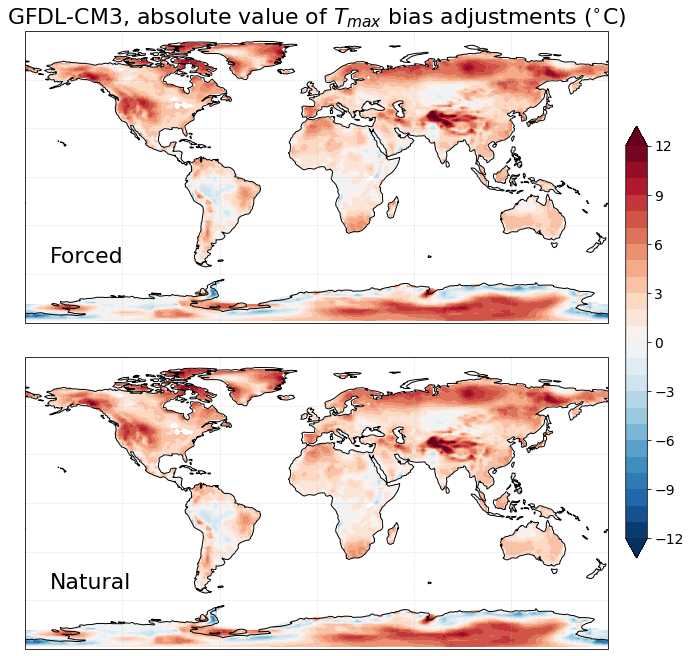

In [12]:
# setup things for the plot
levs=np.arange(-12,12+1,1)

# plot the result
fig=plt.figure(figsize=(12,12))

## FORCED
# create a subplot
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
# plot the 
datp1=ax1.contourf(BA_forced_cyc.lon,BA_forced_cyc.lat,
                   BA_forced_cyc.quantile(qi,dim='time'), \
                        levels=levs, transform=ccrs.PlateCarree(), \
                        cmap='RdBu_r', extend='both')
# draw the coastlines
ax1.coastlines()
ax1.gridlines(alpha=0.25,linestyle=(0, (5, 1)) )
# fig.colorbar(datp1)
# add the scenario string
plt.text(-165,-53,'Forced',color='black',fontsize=22,transform=ccrs.PlateCarree())
plt.title(mname+', absolute value of $T_{max}$ bias adjustments ($^{\circ}$C)',fontsize=22)

## NATURAL
# create a subplot
ax2 = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
# plot the 
datp2=ax2.contourf(BA_natural_cyc.lon,BA_natural_cyc.lat,
                   BA_natural_cyc.quantile(qi,dim='time'), \
                        levels=levs, transform=ccrs.PlateCarree(), \
                        cmap='RdBu_r', extend='both')
# draw the coastlines
ax2.coastlines()
ax2.gridlines(alpha=0.25,linestyle=(0, (5, 1)) )
# add the scenario string
plt.text(-165,-53,'Natural',color='black',fontsize=22,transform=ccrs.PlateCarree())

# make a single large colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.25, 0.025, 0.5])
ticklabs = cbar_ax.get_yticklabels()
cbar_ax.set_yticklabels(levs, fontsize=14)
fig.colorbar(datp1, cax=cbar_ax)

# adjust the white space between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.)
plt.show()

Note that the bias adjustments between the two scenarios have quite a similar magnitude at the median.

## Single Location Empirical Cumulative Distribution Functions

In [13]:
# In order to analyze the emprical CDFs, set some parameters
kwidth=1
kbins=np.arange(20,50+kwidth,kwidth)

### Over the Calibration Period (Fig. S10a)

In [14]:
# get the calibration slice
eg_cal_slice=util.dt64_yrslice(1985, 2015)

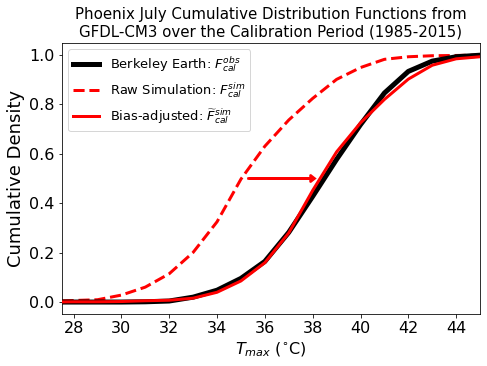

In [15]:
# plot the CDFs
fig, ax1 = plt.subplots(figsize=(7.5,5))

# Observed Temperatures from Berkeley Earth
ax1.plot(kbins,
            ECDF(eg_storage['xobscal'].TMAX.sel(lon=eg_loc[0],lat=eg_loc[1],method='nearest'))(kbins),
            color='k',ls='-',lw=5,label='Berkeley Earth: $F^{obs}_{cal}$',zorder=2)
     
# Simulated Temperatures from eg model     
ax1.plot(kbins,
            ECDF(eg_storage['xsimcal'].TMAX.sel(lon=eg_loc[0],lat=eg_loc[1],method='nearest'))(kbins),
            color='red',ls='--',lw=3,label='Raw Simulation: ${F}^{sim}_{cal}$',zorder=1)
         
ax1.plot(kbins,
            ECDF(eg_storage['forced_xsimadj_BA'].TMAX.sel(lon=eg_loc[0],lat=eg_loc[1],method='nearest').sel(time=eg_cal_slice))(kbins),
            color='red',lw=3,ls='-',label='Bias-adjusted: $\widetilde{F}^{sim}_{cal}$',zorder=3)

# add an arrow between the two values
ax1.arrow(35.3,0.5,2.6,0,lw=2,color='r',head_width=0.03, head_length=0.2,alpha=1)

plt.legend(loc='upper left',fontsize=13)
plt.title('Phoenix July Cumulative Distribution Functions from\n'+mname+' over the Calibration Period (1985-2015)',fontsize=15)

ax1.set_ylabel('Cumulative Density',fontsize=18)
ax1.set_xlabel('$T_{max}$ ($^{\circ}$C)',fontsize=16)
ax1.set_xticks(kbins[0::2])
ax1.set_xticklabels(kbins[0::2],fontsize=16)
ax1.set_yticks(np.arange(0,1+0.2,0.2))
ax1.set_yticklabels([0.,0.2,0.4,0.6,0.8,1.0],fontsize=16)
plt.xlim([27.5,45])

plt.show()

# save the plot out
plot_save_name='figS10a.pdf'
fig.savefig(fig_si_savepath+plot_save_name, dpi=300, bbox_inches='tight')

Were we to repeat this process for every model, the mean percent difference between the observed data (making up the black curve) and the simulated adjusted climate model data (making up the solid red curve) in Phoenix is **~1.6\%**.

### Over the Forced Period (Fig. S10b)

NameError: name 'minyear' is not defined

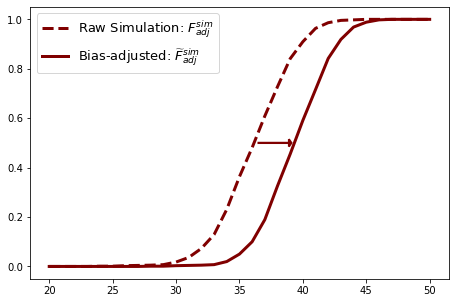

In [17]:
# plot the CDFs
fig, ax1 = plt.subplots(figsize=(7.5,5))
     
# Simulated Temperatures from eg model     
ax1.plot(kbins,
            ECDF(eg_storage['forced_xsimadj_raw'].TMAX.sel(lon=eg_loc[0],lat=eg_loc[1],method='nearest').sel(time=eg_crossing_slice))(kbins),
            color='maroon',ls='--',lw=3,label='Raw Simulation: ${F}^{sim}_{adj}$',zorder=1)
         
ax1.plot(kbins,
            ECDF(eg_storage['forced_xsimadj_BA'].TMAX.sel(lon=eg_loc[0],lat=eg_loc[1],method='nearest').sel(time=eg_crossing_slice))(kbins),
            color='maroon',lw=3,ls='-',label='Bias-adjusted: $\widetilde{F}^{sim}_{adj}$',zorder=2)

# add an arrow between the two values
ax1.arrow(36.5,0.5,2.4,0,lw=2,color='maroon',head_width=0.03, head_length=0.2,alpha=1)

plt.legend(loc='upper left',fontsize=13)
plt.title('Phoenix July Cumulative Distribution Functions from\n'+mname+' over the Forced Period ('+str(cross_dat.loc[mname]['FirstYear'])+'-'+str(cross_dat.loc[mname]['LastYear'])+')',fontsize=15)

ax1.set_ylabel('Cumulative Density',fontsize=18)
ax1.set_xlabel('$T_{max}$ ($^{\circ}$C)',fontsize=16)
ax1.set_xticks(kbins[0::2])
ax1.set_xticklabels(kbins[0::2],fontsize=16)
ax1.set_yticks(np.arange(0,1+0.2,0.2))
ax1.set_yticklabels([0.,0.2,0.4,0.6,0.8,1.0],fontsize=16)
plt.xlim([27.5,45])

plt.show()

# save the plot out
plot_save_name='figS10b.pdf'
fig.savefig(fig_si_savepath+plot_save_name, dpi=300, bbox_inches='tight')